In [34]:
# DataFrame
import pandas as pd
import numpy as np
import random
import time
from datetime import datetime, date

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import itertools
import re

# Visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import warnings

# Save the log
import os
import pickle

import holidays

# Model
from lightgbm import LGBMRegressor

# optuna
import optuna
from optuna.samplers import TPESampler
# optuna.logging.set_verbosity(optuna.logging.WARNING)

# Metric
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score

# font Setting
plt.rc('font', family='Malgun Gothic')
# Minus
matplotlib.rcParams['axes.unicode_minus'] = False

In [37]:
# pd.set_option('display.max_rows', 100)
raw_df=pd.read_csv('../data/line_data_result.csv')
raw_df.drop(columns=['Unnamed: 0', 'ServoSpeed'], inplace=True)

raw_df = raw_df.replace({'OK': 1, 'NG':0})

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_32252\4201519900.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  raw_df = raw_df.replace({'OK': 1, 'NG':0})


In [46]:
target_columns = ['Result',
       '그루브깊이1번_Result', '그루브깊이2번_Result', '그루브깊이3번_Result', '그루브깊이4번_Result',
       '그루브깊이5번_Result', '진원도1번_Result', '진원도2번_Result', '진원도3번_Result',
       '진원도4번_Result', '진원도5번_Result', '위치도1번_Result', '위치도2번_Result',
       '위치도3번_Result', '위치도4번_Result', '위치도5번_Result', '내경_Result',
       '그루브경1번_Result', '그루브경2번_Result', '그루브경3번_Result', '그루브경4번_Result',
       '그루브경5번_Result']

In [60]:
# Prepare df

raw_df=pd.read_csv('../data/ts_data.csv')

raw_df['ReceivedDateTime'] = pd.to_datetime(raw_df['ReceivedDateTime'])

raw_df.sort_values('ReceivedDateTime', inplace=True)

In [62]:
# OK, NG 개수 데이터 셋에서 파악
result_lst = ['내경_Result', '그루브깊이_Result', '위치도_Result', '진원도_Result', '그루브경_Result', 'Result']

for res in result_lst:
    train = raw_df[(raw_df['ReceivedDateTime'] < pd.to_datetime('2023-06-01')) & (raw_df[res] == 0)].groupby('SerialNo').size()
    test = raw_df[(raw_df['ReceivedDateTime'] >= pd.to_datetime('2023-06-01')) & (raw_df[res] == 0)].groupby('SerialNo').size()

    print(res, len(train), len(test))

# 전체 SerialNo 개수 출력
total_serials = raw_df[raw_df['ReceivedDateTime'] >= '2023-06-01'].groupby('SerialNo').size()
print(len(total_serials))


내경_Result 19 0
그루브깊이_Result 43 41
위치도_Result 227 71
진원도_Result 0 1
그루브경_Result 0 1
Result 242 107
2599


In [49]:
def add_result(df):
    result_mapping = {
        '그루브깊이': ['그루브깊이1번_Result', '그루브깊이2번_Result', '그루브깊이3번_Result', '그루브깊이4번_Result', '그루브깊이5번_Result'],
        '위치도': ['위치도1번_Result', '위치도2번_Result', '위치도3번_Result', '위치도4번_Result', '위치도5번_Result'],
        '진원도': ['진원도1번_Result', '진원도2번_Result', '진원도3번_Result', '진원도4번_Result', '진원도5번_Result'],
        '그루브경': ['그루브경1번_Result', '그루브경2번_Result', '그루브경3번_Result', '그루브경4번_Result', '그루브경5번_Result']
    }

    # ***_Result 열 4개 추가
    for new_col, related_cols in result_mapping.items():
        df[f'{new_col}_Result'] = df[related_cols].apply(lambda x: 0 if (x == 0).any() else 1, axis=1)
    
    return df

In [7]:
# 변수 시각화
# SerialNo별 그룹핑 후 조건에 따라 True를 만족하는 SerialNo를 추출
valid_serials = raw_df.groupby('SerialNo').size() < raw_df.groupby('SerialNo').size().quantile(0.75)
true_serials = valid_serials[valid_serials].index  # True인 SerialNo만 추출

# 원본 데이터프레임에서 해당 SerialNo만 필터링
filtered_df = raw_df[raw_df['SerialNo'].isin(true_serials)]

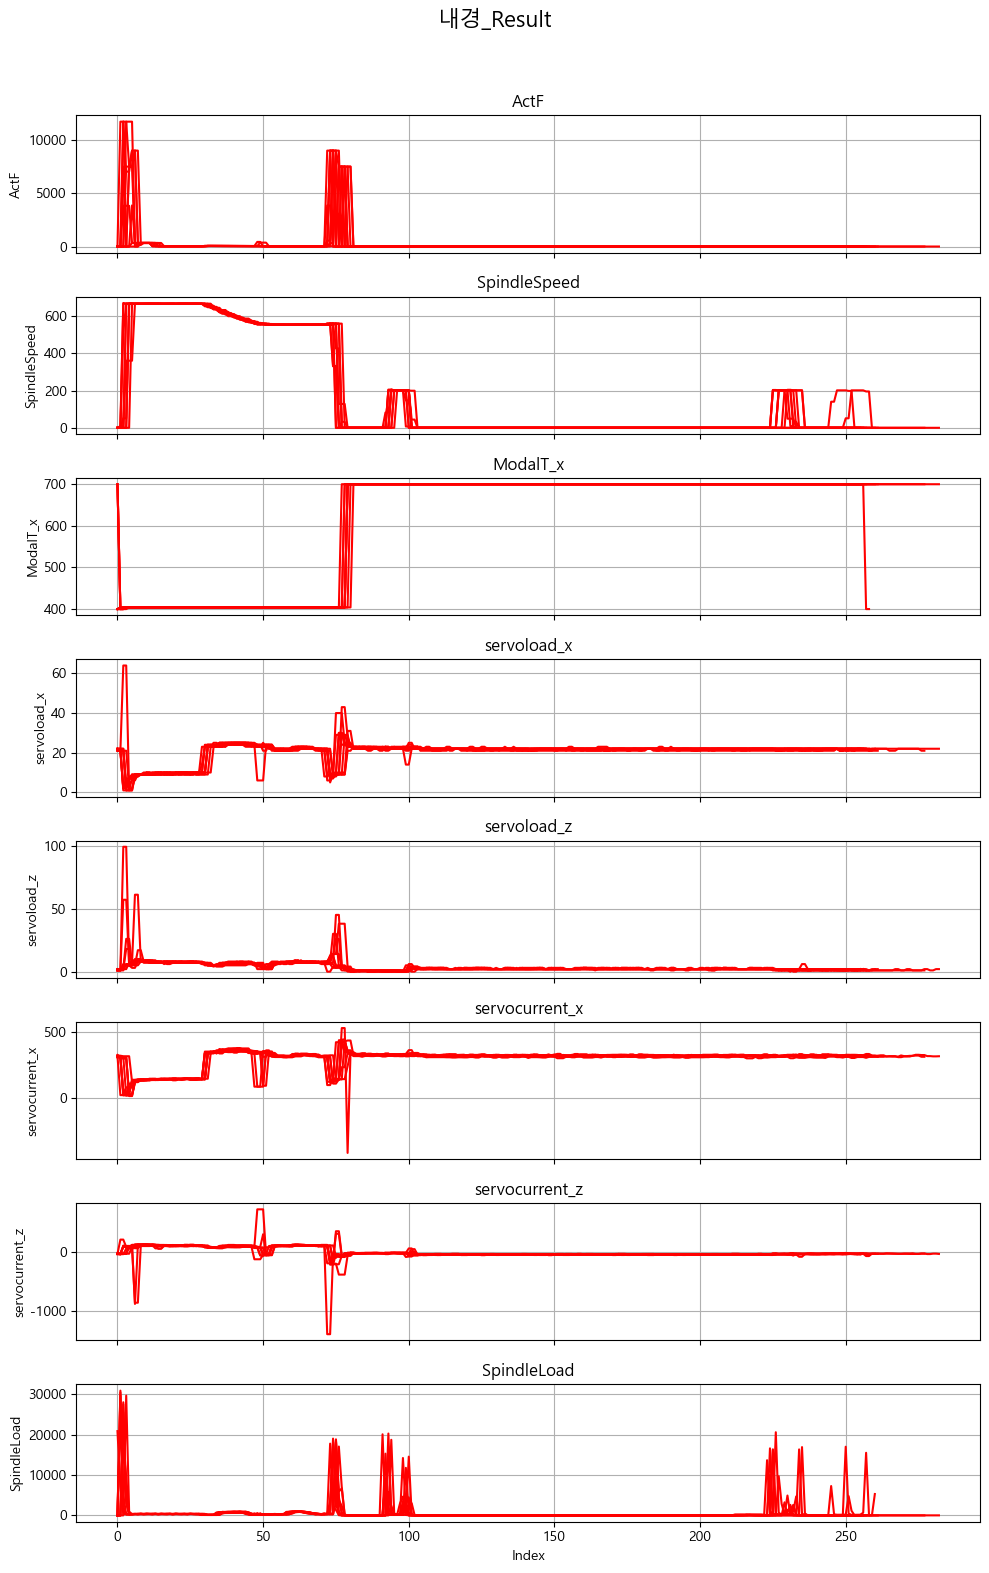

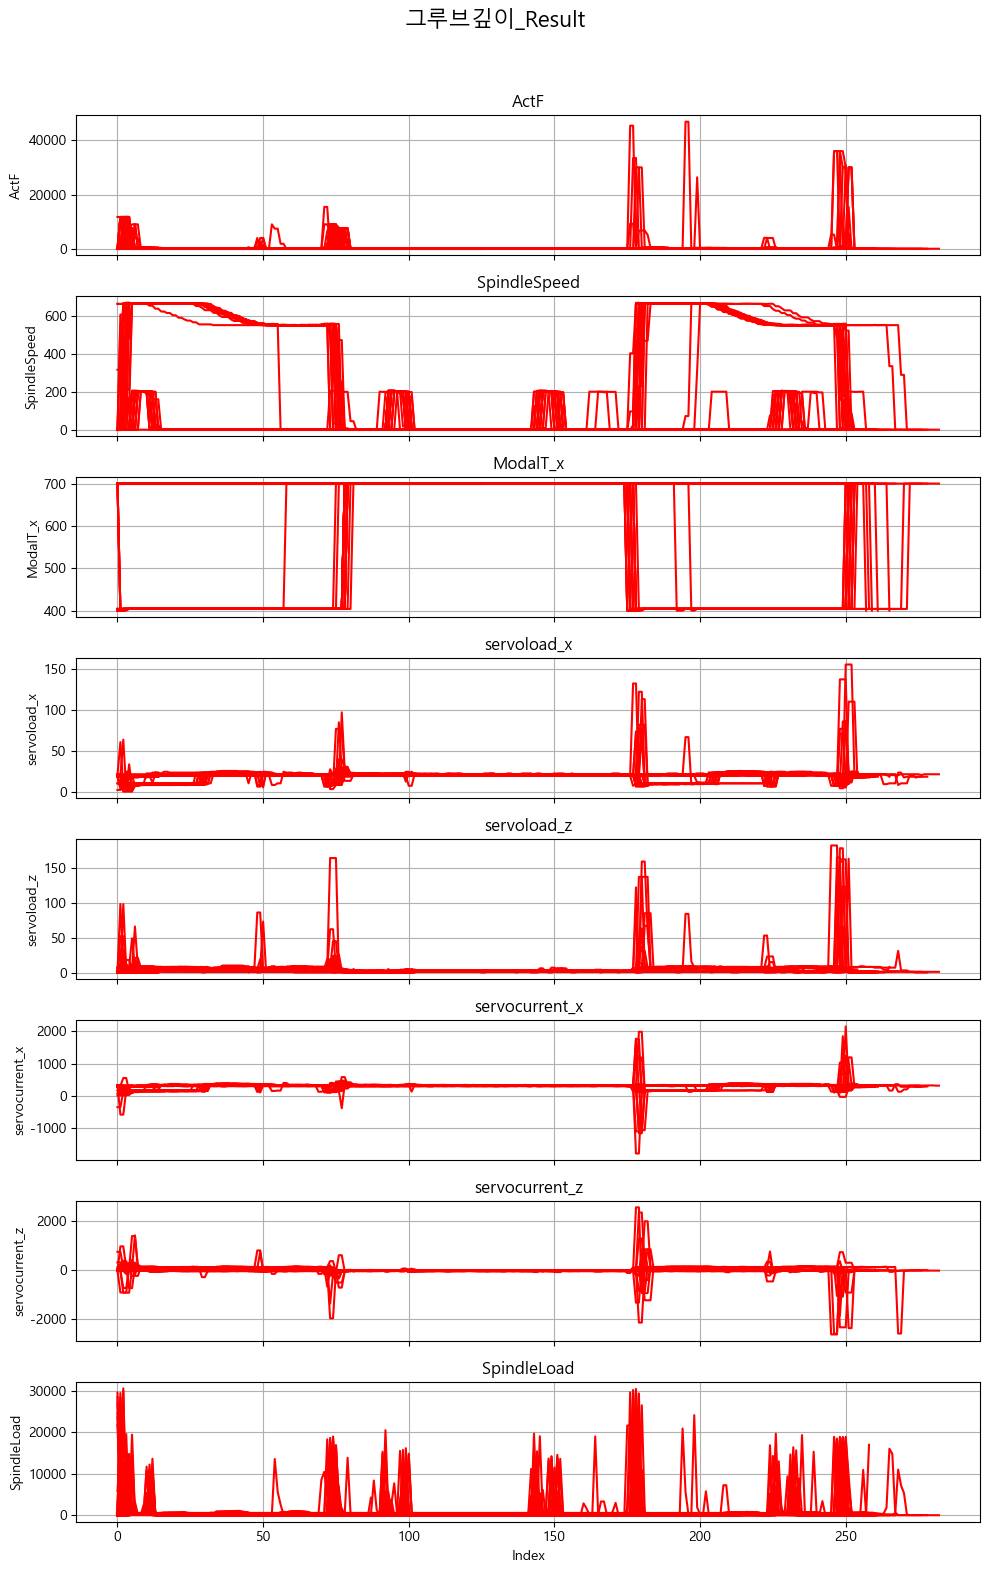

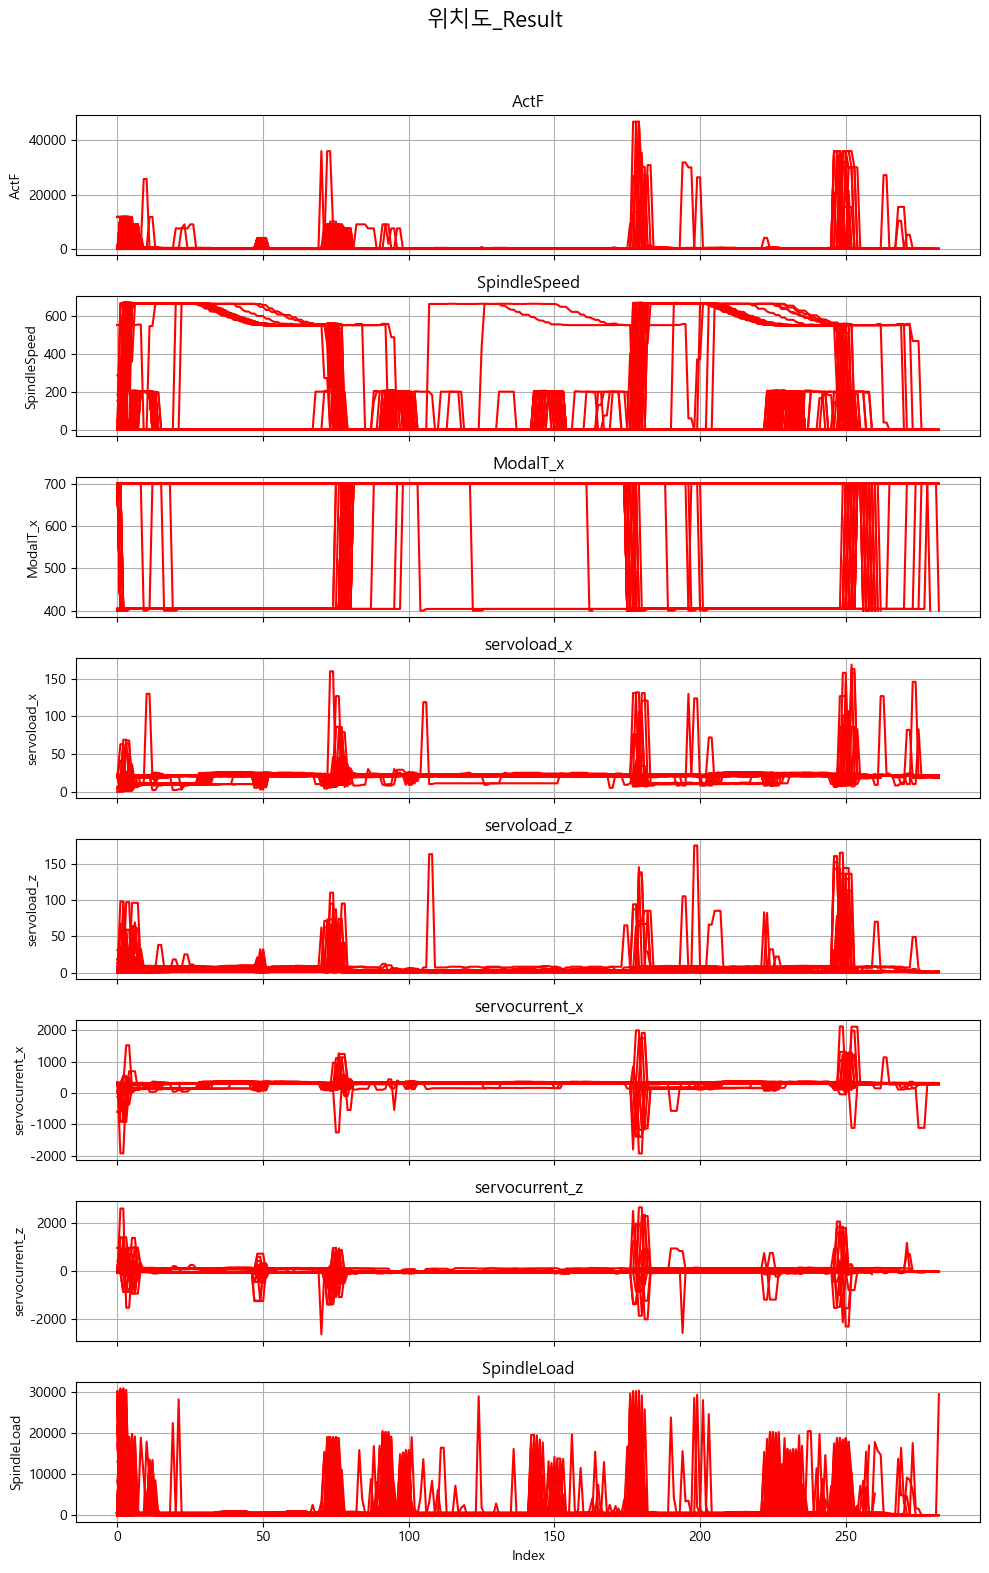

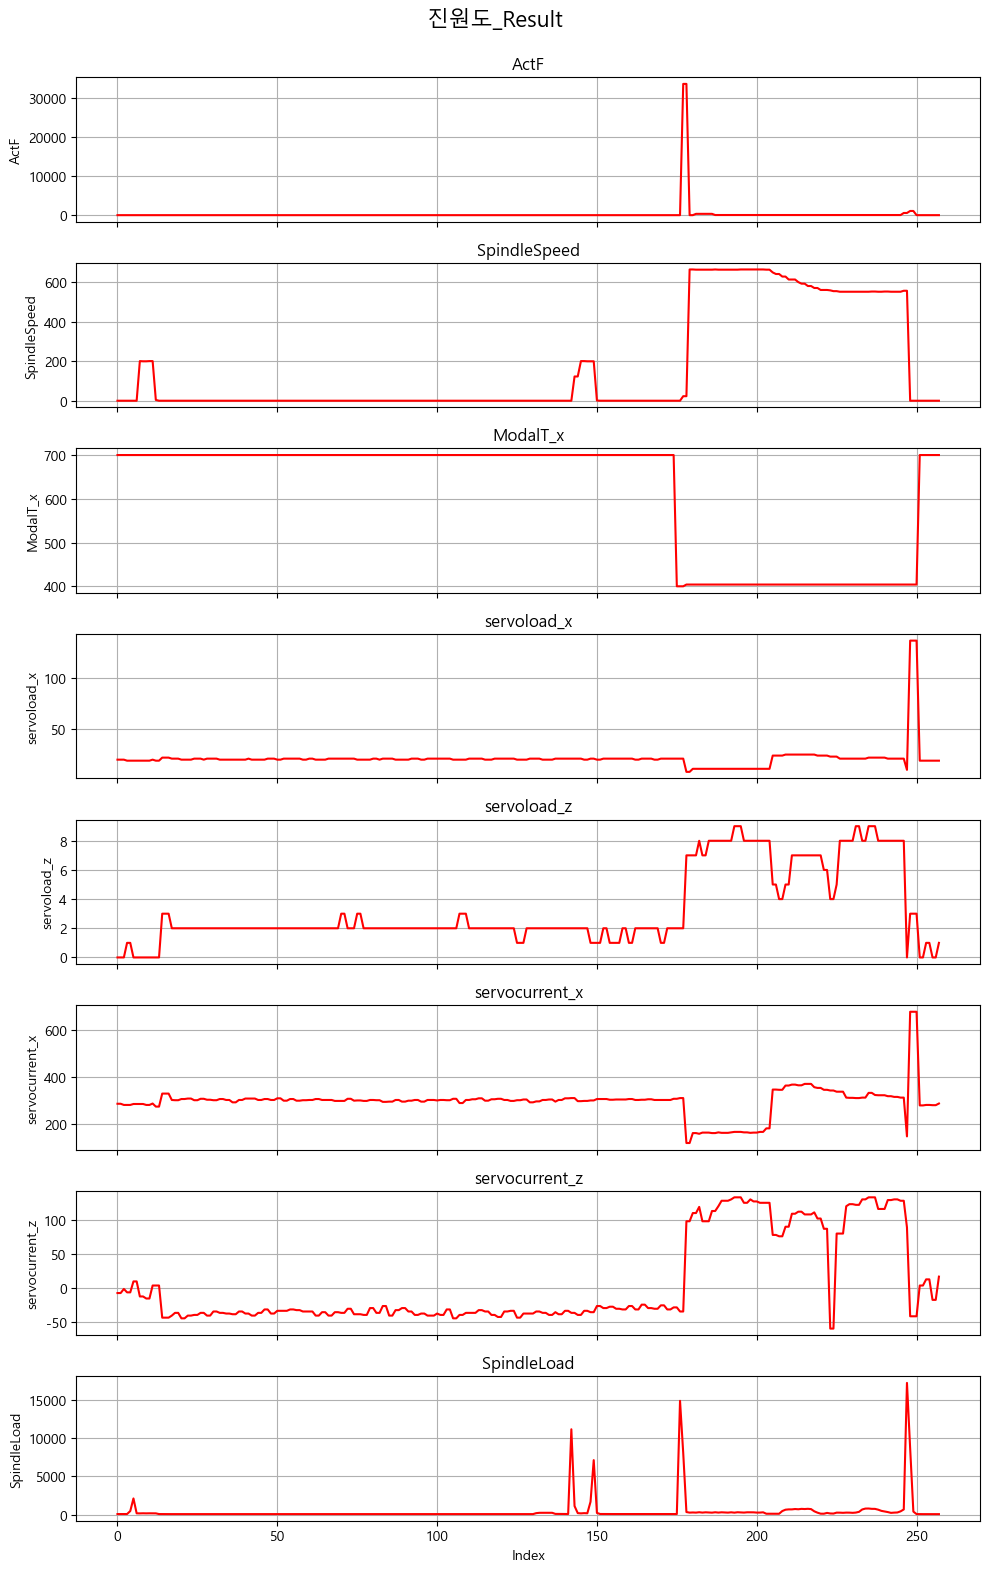

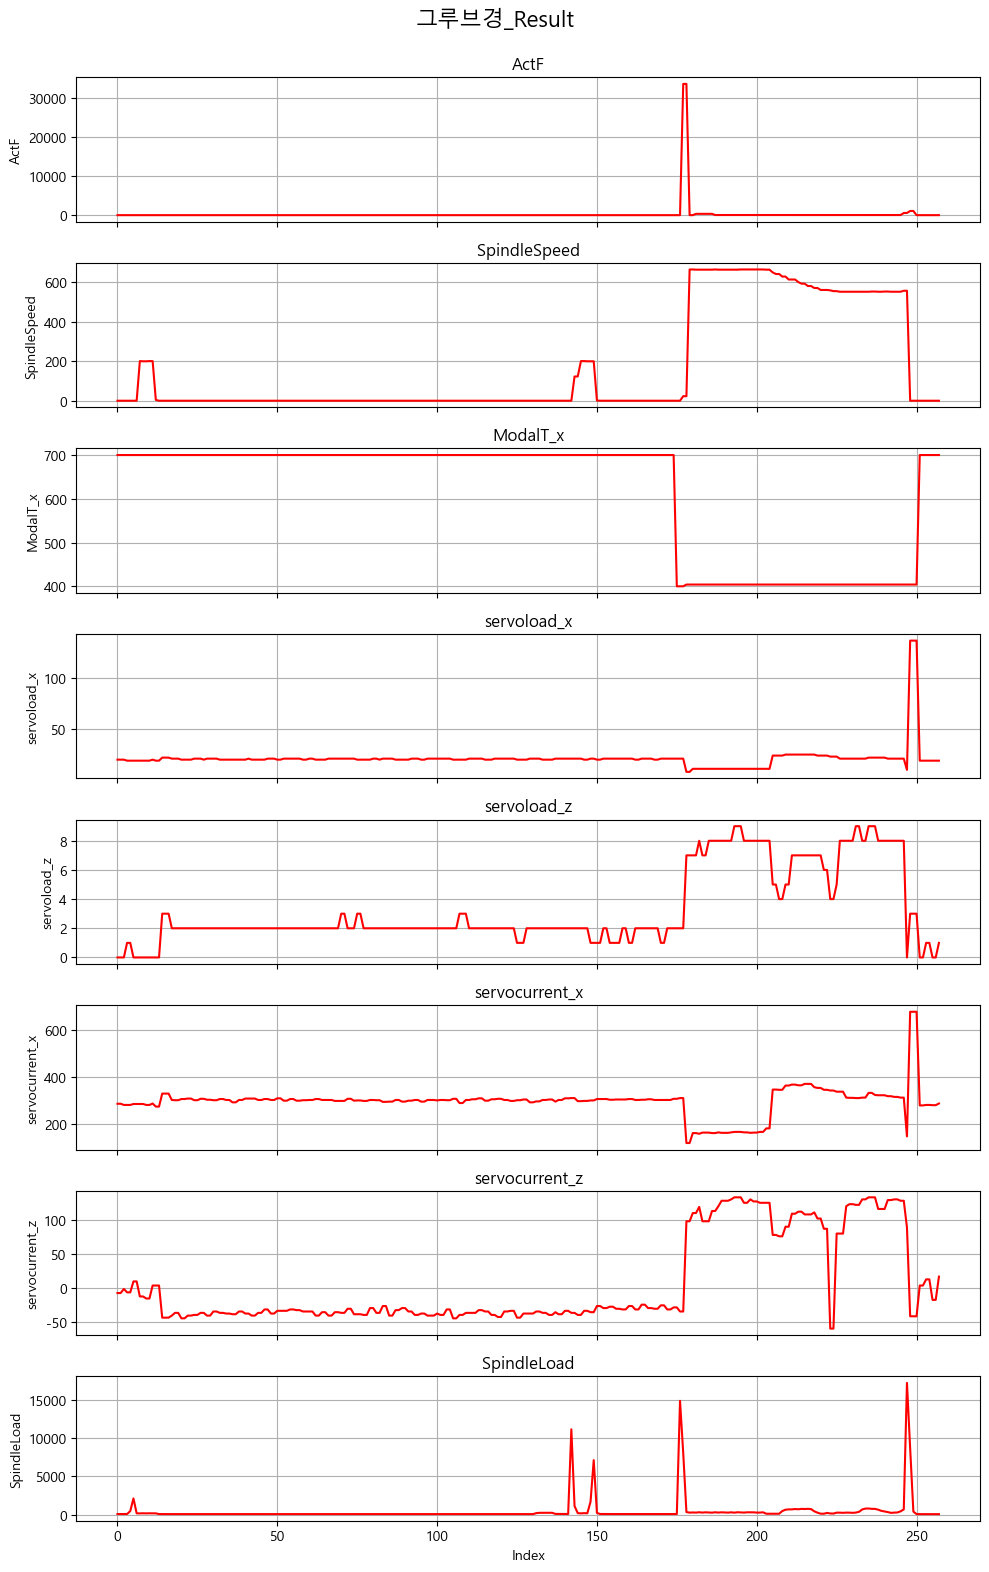

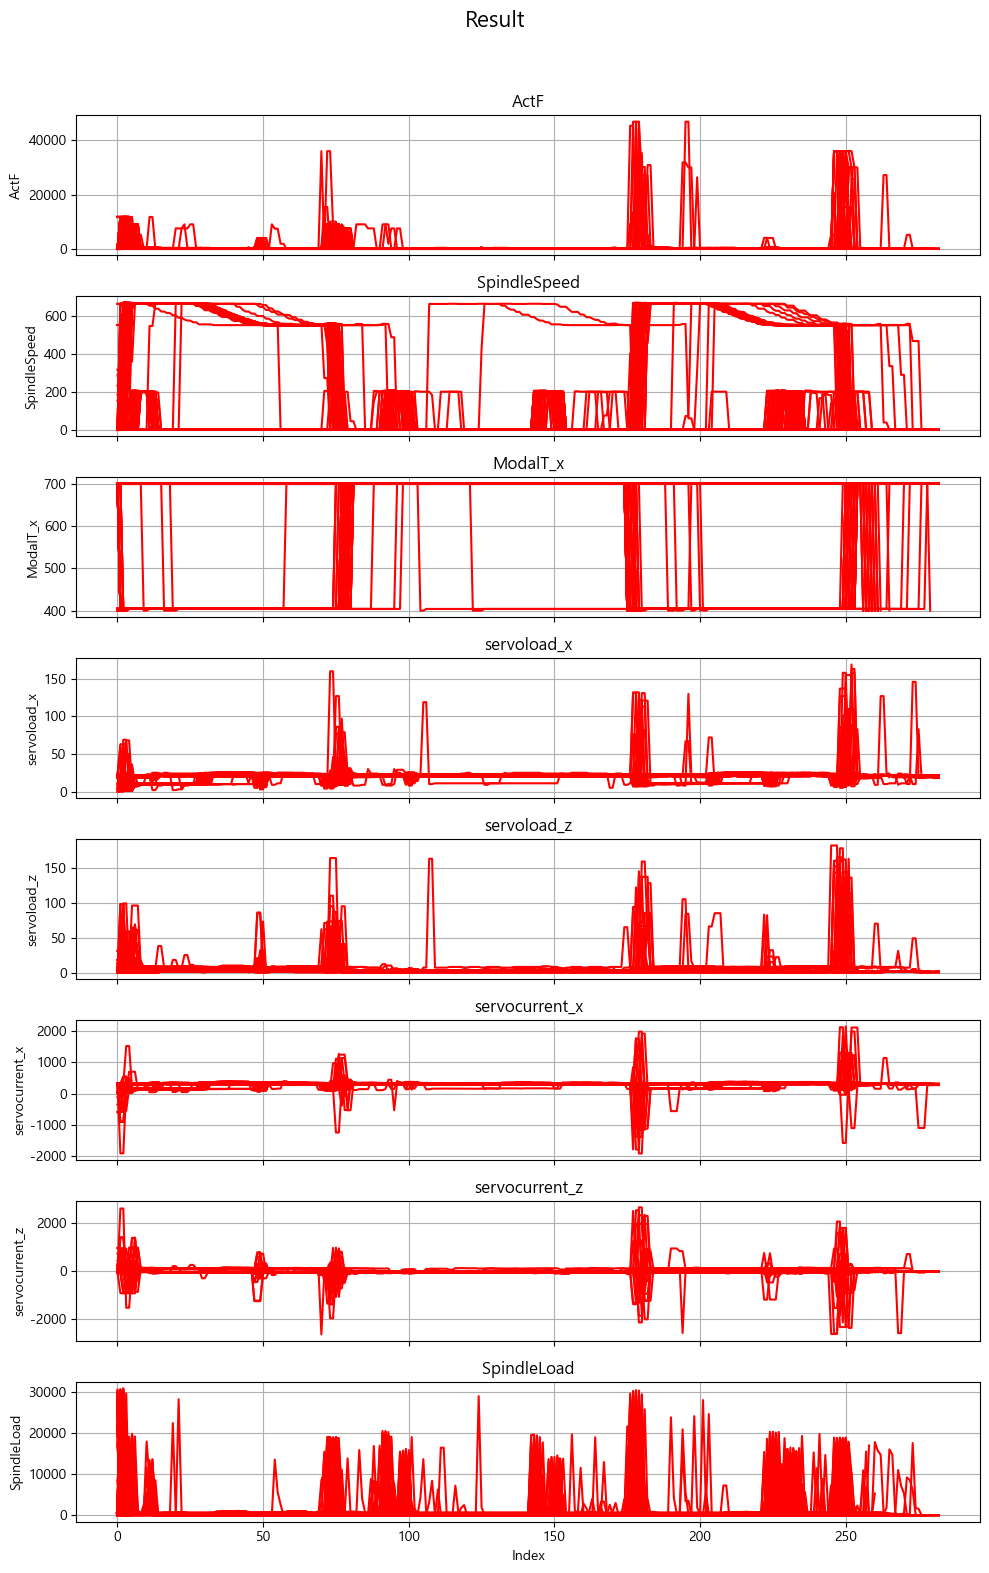

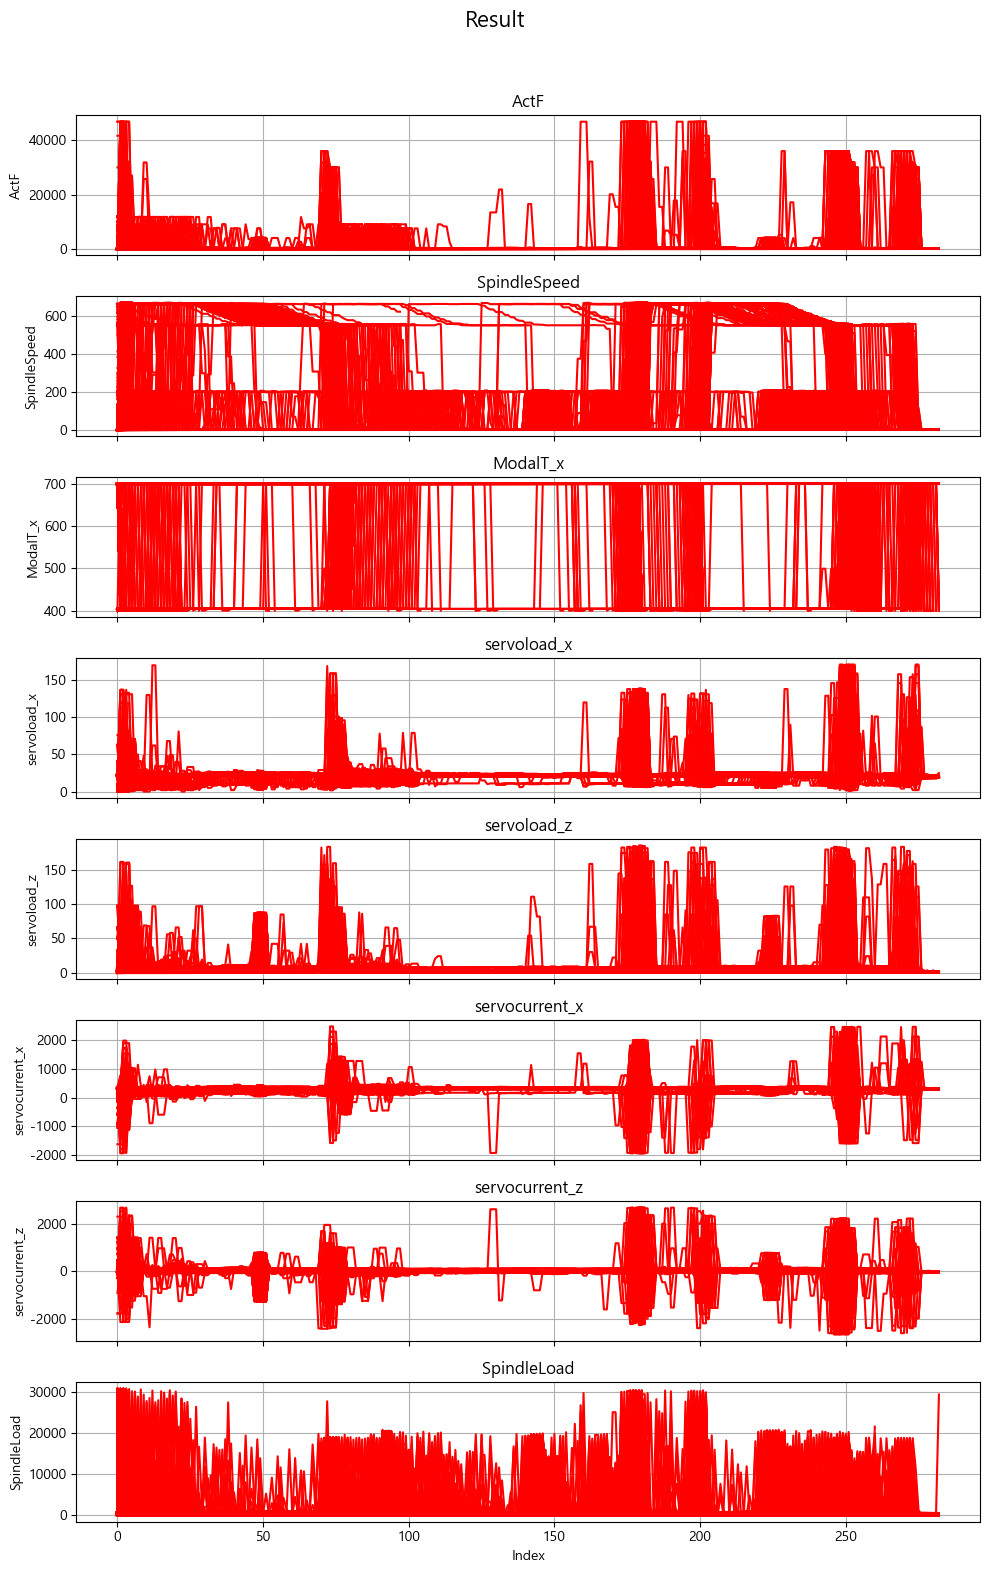

In [8]:
# 변수 피처 EDA
# 변수 목록
columns_to_plot = [
 'ActF', 'SpindleSpeed',
    'ModalT_x',  'servoload_x', 'servoload_z',
    'servocurrent_x', 'servocurrent_z', 'SpindleLoad'
]

result_lst = ['내경_Result', '그루브깊이_Result', '위치도_Result', '진원도_Result', '그루브경_Result','Result']

for res in result_lst:
    # Subplot 생성
    fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(10, len(columns_to_plot) * 2), sharex=True)


    serial_lst = filtered_df[filtered_df[res]==0]['SerialNo'].unique()
    
    for s_num in serial_lst:
        #print(s_num)

        tmp_df = filtered_df[filtered_df['SerialNo']==s_num]
        tmp_df.reset_index(drop=True, inplace=True)
        for i, column in enumerate(columns_to_plot):
            axes[i].plot(tmp_df.index, tmp_df[column], color='r')
            axes[i].set_title(column)
            axes[i].grid(True)
            axes[i].set_ylabel(column)
        

        plt.xlabel('Index')

        # 간격 조정
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # rect로 suptitle 공간 확보
        plt.suptitle(res, fontsize=16)
        
    plt.show()

# Subplot 생성
fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(10, len(columns_to_plot) * 2), sharex=True)
serial_lst = filtered_df[filtered_df['Result']==1]['SerialNo'].unique()

for s_num in serial_lst:
    #print(s_num)
    tmp_df = filtered_df[filtered_df['SerialNo']==s_num]
    tmp_df.reset_index(drop=True, inplace=True)
    for i, column in enumerate(columns_to_plot):
        axes[i].plot(tmp_df.index, tmp_df[column], color='r')
        axes[i].set_title(column)
        axes[i].grid(True)
        axes[i].set_ylabel(column)
    
    plt.xlabel('Index')
    # 간격 조정
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # rect로 suptitle 공간 확보
    plt.suptitle(res, fontsize=16)
    
plt.show()

In [67]:
# 시계열 대푯값 추출
# RestartCount와 TotalCount는 mean()으로, 다른 열은 첫 번째 값으로 집계
aggregations = {
    'RestartCount': 'mean',
    'TotalCount': 'mean',
    'Result': 'first',
    '그루브깊이1번_Result': 'first',
    '그루브깊이2번_Result': 'first',
    '그루브깊이3번_Result': 'first',
    '그루브깊이4번_Result': 'first',
    '그루브깊이5번_Result': 'first',
    '진원도1번_Result': 'first',
    '진원도2번_Result': 'first',
    '진원도3번_Result': 'first',
    '진원도4번_Result': 'first',
    '진원도5번_Result': 'first',
    '위치도1번_Result': 'first',
    '위치도2번_Result': 'first',
    '위치도3번_Result': 'first',
    '위치도4번_Result': 'first',
    '위치도5번_Result': 'first',
    '내경_Result': 'first',
    '그루브경1번_Result': 'first',
    '그루브경2번_Result': 'first',
    '그루브경3번_Result': 'first',
    '그루브경4번_Result': 'first',
    '그루브경5번_Result': 'first'
}

# groupby를 사용하여 집계
grouped_result = raw_df.groupby('SerialNo').agg(aggregations)
grouped_result.reset_index(inplace=True)

array(['20230103-0004-00194', '20230104-0000-00572',
       '20230104-0000-00584', '20230105-0003-00090',
       '20230107-0000-00184', '20230110-0003-00049',
       '20230111-0000-00397', '20230112-0000-00417',
       '20230114-0000-00107', '20230114-0000-00249',
       '20230202-0003-00106', '20230202-0003-00270',
       '20230202-0003-00310', '20230328-0000-00235',
       '20230330-0000-00272', '20230331-0000-00151',
       '20230331-0000-00165', '20230403-0005-00054',
       '20230403-0005-00094', '20230404-0006-00174',
       '20230405-0004-00023', '20230629-0007-00123',
       '20230703-0010-00024', '20230703-0010-00038',
       '20230704-0000-00170', '20230704-0004-00036',
       '20230704-0004-00076', '20230705-0005-00076',
       '20230706-0000-00288', '20230706-0000-00356',
       '20230706-0000-00452', '20230706-0001-00059',
       '20230707-0000-00183', '20230707-0000-00497',
       '20230707-0000-00499'], dtype=object)